### 1. Setup: Install Dependencies

This cell installs all the necessary Python libraries. It includes special steps to install the `TA-Lib` library correctly within the Google Colab environment, followed by other standard data science and machine learning packages.

In [26]:
print("Installing libraries...")
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1 > /dev/null 2>&1
!pip install -q conda-package-handling
!wget -q https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda > /dev/null 2>&1
# Adjust python3.11 below if your Colab environment uses a different version
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/ > /dev/null 2>&1
# Other libraries
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn joblib mplfinance --quiet
print("Dependencies installed.")
try:
    import talib
    print("TA-Lib imported successfully!")
except ImportError:
    print("⚠️ Failed to import TA-Lib after installation.")

Installing libraries...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4059    0  4059    0     0   8667      0 --:--:-- --:--:-- --:--:--  8673
100  517k  100  517k    0     0   590k      0 --:--:-- --:--:-- --:--:-- 2735k
Dependencies installed.
TA-Lib imported successfully!


### 2. Setup: Import Libraries

Here, we import all the installed libraries that we will use for data handling, analysis, modeling, and visualization.

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
# import talib as ta # Keep import if needed for future EDA/features
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf # For candlestick charts
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# Configure plotting style and suppress warnings
plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
print("✅ Libraries imported.")

✅ Libraries imported.


### 3. Data Acquisition: Download Nifty 50 Data

We use the `yfinance` library to download the maximum available historical daily data for the NIFTY 50 index (`^NSEI`). We use `auto_adjust=False` to get the standard Open, High, Low, Close columns.

In [28]:
# Cell 3
ticker = "^NSEI"
print(f"Downloading max history for {ticker}...")
nifty_data_raw = yf.download(ticker, period="max", auto_adjust=False)
print(f"Data downloaded: {nifty_data_raw.shape[0]} rows.")

[*********************100%***********************]  1 of 1 completed

Data downloaded: 4310 rows.


### 4. Data Acquisition: Save Raw Data

It's good practice to save the original downloaded data. We save it as a CSV file in a `data` folder, creating the folder if it doesn't exist.

In [29]:
# Cell 4
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)
raw_data_path = os.path.join(data_dir, 'NIFTY50_raw_max.csv')
nifty_data_raw.to_csv(raw_data_path)
print(f"✅ Raw data saved to {raw_data_path}")

✅ Raw data saved to data/NIFTY50_raw_max.csv


### 5. Data Acquisition: Inspect Raw Data Sample

Let's look at the last few rows of the raw downloaded data to check its structure and recent values.

In [30]:
# Cell 5
print("--- Raw Data Sample (Tail) ---")
print(nifty_data_raw.tail())

--- Raw Data Sample (Tail) ---
Price          Adj Close         Close          High           Low  \
Ticker             ^NSEI         ^NSEI         ^NSEI         ^NSEI   
Date                                                                 
2025-04-09  22399.150391  22399.150391  22468.699219  22353.250000   
2025-04-11  22828.550781  22828.550781  22923.900391  22695.400391   
2025-04-15  23328.550781  23328.550781  23368.349609  23207.000000   
2025-04-16  23437.199219  23437.199219  23452.199219  23273.050781   
2025-04-17  23851.650391  23851.650391  23872.349609  23298.550781   

Price               Open  Volume  
Ticker             ^NSEI   ^NSEI  
Date                              
2025-04-09  22460.300781  383800  
2025-04-11  22695.400391  402200  
2025-04-15  23368.349609  388300  
2025-04-16  23344.099609  348400  
2025-04-17  23401.849609  505300  


### 6. Data Preparation: Rename Columns

We simplify the column names downloaded by `yfinance` (which might be complex MultiIndex or include uppercase letters) to simple lowercase names like 'open', 'high', 'low', 'close', 'volume'. This handles potential `AttributeError` issues.

In [31]:
# Cell 6: Rename Columns (Revised to handle MultiIndex)
print("--- Renaming Columns ---")

# Check if columns are MultiIndex
if isinstance(nifty_data_raw.columns, pd.MultiIndex):
    print("Detected MultiIndex columns. Flattening...")
    # Flatten MultiIndex: Take the first level (e.g., 'Open', 'High')
    nifty_data_raw.columns = nifty_data_raw.columns.get_level_values(0)
    # Convert to lowercase
    nifty_data_raw.columns = [col.lower() for col in nifty_data_raw.columns]
else:
    # If already single index, just convert to lowercase
    print("Detected single index columns. Converting to lowercase...")
    nifty_data_raw.columns = [col.lower() for col in nifty_data_raw.columns]

# Remove potential duplicates if flattening caused issues (e.g., multiple 'Adj Close')
# Keep the first occurrence
nifty_data_raw = nifty_data_raw.loc[:,~nifty_data_raw.columns.duplicated()]

print("\nColumns after processing:")
print(nifty_data_raw.columns.tolist()) # Show list of columns
print("\n--- Head after renaming ---")
print(nifty_data_raw.head())

--- Renaming Columns ---
Detected MultiIndex columns. Flattening...

Columns after processing:
['adj close', 'close', 'high', 'low', 'open', 'volume']

--- Head after renaming ---
              adj close        close         high          low         open  \
Date                                                                          
2007-09-17  4494.649902  4494.649902  4549.049805  4482.850098  4518.450195   
2007-09-18  4546.200195  4546.200195  4551.799805  4481.549805  4494.100098   
2007-09-19  4732.350098  4732.350098  4739.000000  4550.250000  4550.250000   
2007-09-20  4747.549805  4747.549805  4760.850098  4721.149902  4734.850098   
2007-09-21  4837.549805  4837.549805  4855.700195  4733.700195  4752.950195   

            volume  
Date                
2007-09-17       0  
2007-09-18       0  
2007-09-19       0  
2007-09-20       0  
2007-09-21       0  


### 7. Data Preparation: Handle Missing Values

We check for any missing data points (NaNs) in the dataset and remove rows containing them to ensure data integrity for modeling.

In [32]:
# Cell 7
print("\n--- Handling Missing Values ---")
initial_rows = len(nifty_data_raw)
nifty_data_raw.dropna(inplace=True)
print(f"Dropped {initial_rows - len(nifty_data_raw)} rows with NaNs.")
print(f"Shape after handling NaNs: {nifty_data_raw.shape}")


--- Handling Missing Values ---
Dropped 0 rows with NaNs.
Shape after handling NaNs: (4310, 6)


### 8. Data Preparation: Create Target Variable

Our goal is to predict the *next* day's high price. We create a new column `next_day_high` by shifting the 'high' column's values up by one day. The last row will have a NaN for this new column, so we remove that row.

In [33]:
# Cell 8
print("\n--- Creating Target Variable ---")
nifty_data_raw['next_day_high'] = nifty_data_raw['high'].shift(-1)
nifty_data_raw.dropna(subset=['next_day_high'], inplace=True)
print(f"Target 'next_day_high' created. Final shape: {nifty_data_raw.shape}")
print("\n--- Processed Data Sample (Tail) ---")
print(nifty_data_raw[['open', 'high', 'low', 'close', 'next_day_high']].tail())


--- Creating Target Variable ---
Target 'next_day_high' created. Final shape: (4309, 7)

--- Processed Data Sample (Tail) ---
                    open          high           low         close  \
Date                                                                 
2025-04-08  22446.750000  22697.199219  22270.849609  22535.849609   
2025-04-09  22460.300781  22468.699219  22353.250000  22399.150391   
2025-04-11  22695.400391  22923.900391  22695.400391  22828.550781   
2025-04-15  23368.349609  23368.349609  23207.000000  23328.550781   
2025-04-16  23344.099609  23452.199219  23273.050781  23437.199219   

            next_day_high  
Date                       
2025-04-08   22468.699219  
2025-04-09   22923.900391  
2025-04-11   23368.349609  
2025-04-15   23452.199219  
2025-04-16   23872.349609  


### 9. Feature Selection: Define Features (X) and Target (y)

We separate the prepared data into our input features (X), which are today's Open, High, Low, and Close prices, and the target variable (y), which is the Next Day's High price we just created.

In [34]:
# Cell 9
print("--- Defining Features and Target ---")
feature_columns = ['open', 'high', 'low', 'close']
X = nifty_data_raw[feature_columns]
y = nifty_data_raw['next_day_high']
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
assert len(X) == len(y), "Alignment Error!"

--- Defining Features and Target ---
Features (X) shape: (4309, 4)
Target (y) shape: (4309,)


### 10. EDA: Candlestick Chart

Visualize the recent price action (last 100 days) using a candlestick chart. This helps understand recent trends, volatility, and price patterns in the Nifty 50 index.

--- EDA: Candlestick Chart (Last 100 Days) ---


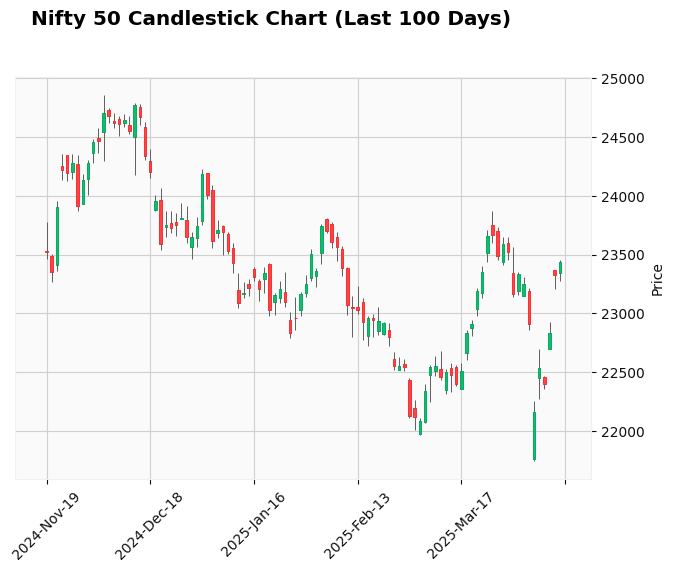

In [35]:
# Cell 10
print("--- EDA: Candlestick Chart (Last 100 Days) ---")
mpf.plot(nifty_data_raw.tail(100), type='candle', style='yahoo',
         title='Nifty 50 Candlestick Chart (Last 100 Days)',
         ylabel='Price')
plt.show()

### 11. EDA: Target Variable Distribution

Plot a histogram of the target variable (`next_day_high`) to understand the distribution and range of the values our model will try to predict.


--- EDA: Distribution of Target Variable (Next Day High) ---


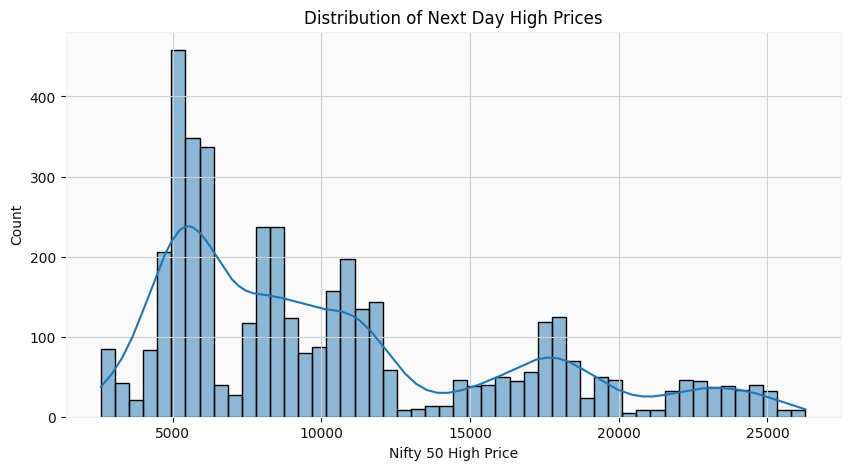

In [36]:
# Cell 11
print("\n--- EDA: Distribution of Target Variable (Next Day High) ---")
plt.figure(figsize=(10, 5))
sns.histplot(y, kde=True, bins=50)
plt.title('Distribution of Next Day High Prices')
plt.xlabel('Nifty 50 High Price')
plt.show()

### 12. EDA: Input Feature Distributions

Plot histograms for the input features (Open, High, Low, Close) using the *training portion* of the data (before scaling) to understand their individual distributions.


--- EDA: Input Feature Distributions (Training Set - Before Scaling) ---


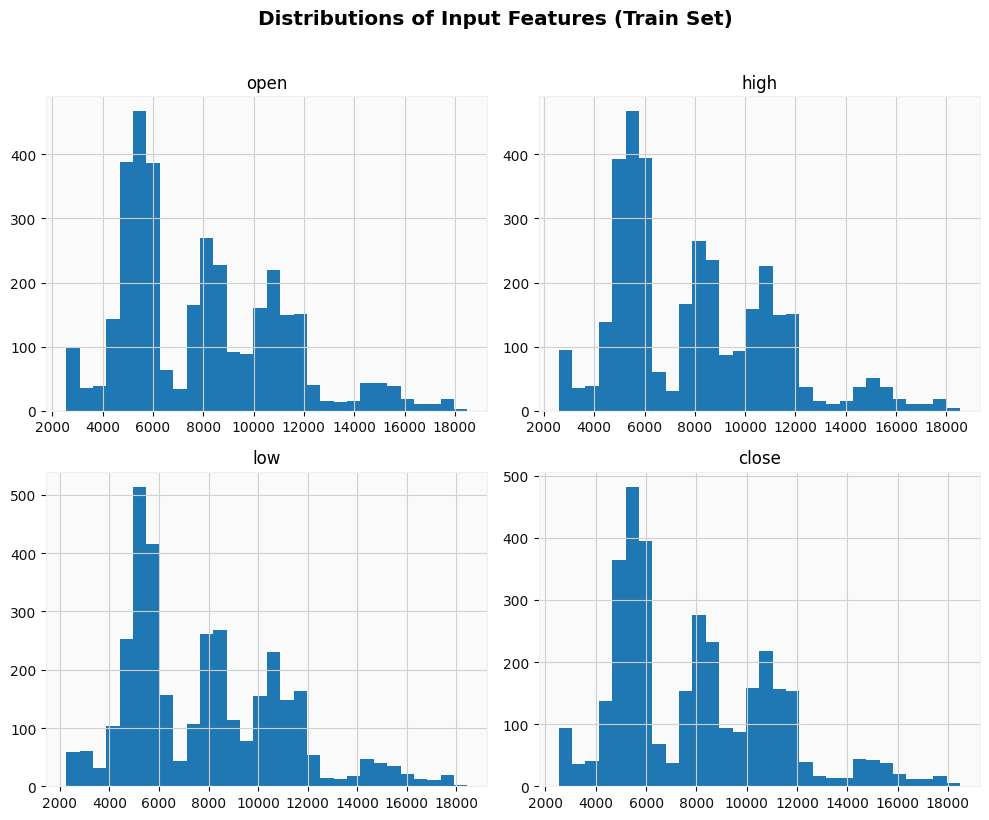

In [37]:
# Cell 12
print("\n--- EDA: Input Feature Distributions (Training Set - Before Scaling) ---")
temp_split_index = int(len(X) * 0.8)
X_train_temp = X[:temp_split_index]
X_train_temp.hist(figsize=(10, 8), bins=30)
plt.suptitle('Distributions of Input Features (Train Set)', y=1.02)
plt.tight_layout()
plt.show()
del X_train_temp

### 13. EDA: Input Feature Correlations

Visualize the linear correlation *between* the input features (Open, High, Low, Close) using a heatmap. High correlation between input features (multicollinearity) can sometimes affect linear model interpretation but is expected here (e.g., Open and Close are usually related).


--- EDA: Correlation Matrix of Input Features (Training Set) ---


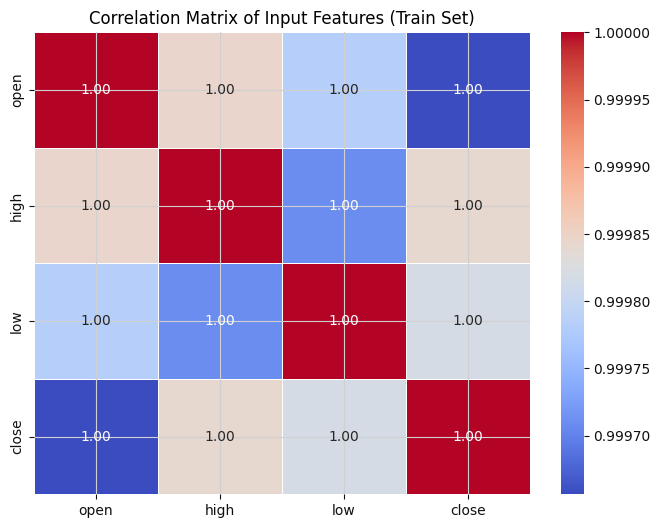

In [38]:
# Cell 13
print("\n--- EDA: Correlation Matrix of Input Features (Training Set) ---")
temp_split_index = int(len(X) * 0.8)
X_train_temp = X[:temp_split_index]
plt.figure(figsize=(8, 6))
sns.heatmap(X_train_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Input Features (Train Set)')
plt.show()
del X_train_temp

### 14. Data Splitting: Train/Test Split

Divide the data chronologically into training (80%) and testing (20%) sets. The model learns from the training set and its performance is evaluated on the unseen testing set.

In [39]:
# Cell 14
print("--- Splitting Data (80% Train, 20% Test) ---")
split_percentage = 0.8
split_index = int(len(X) * split_percentage)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

--- Splitting Data (80% Train, 20% Test) ---
Train shapes: X=(3447, 4), y=(3447,)
Test shapes:  X=(862, 4), y=(862,)


### 15. Data Preprocessing: Scale Features

Scale the input features using `StandardScaler`. This transforms the data to have zero mean and unit variance, which helps the Linear Regression model converge properly and treats all features equally. **Important:** Fit the scaler *only* on training data.

In [40]:
# Cell 15
print("\n--- Scaling Features ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using StandardScaler.")


--- Scaling Features ---
Features scaled using StandardScaler.


### 16. Model Training: Train Linear Regression Model

Train the Linear Regression model using the scaled training features (`X_train_scaled`) and the corresponding target values (`y_train`).

In [41]:
# Cell 16
print("--- Training Linear Regression Model ---")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("✅ Model trained.")
print("\n--- Model Coefficients ---")
coefficients = pd.DataFrame(lr_model.coef_, index=X.columns, columns=['Coefficient'])
print(coefficients)
print(f"\nModel Intercept: {lr_model.intercept_:.4f}")

--- Training Linear Regression Model ---
✅ Model trained.

--- Model Coefficients ---
       Coefficient
open   -241.634281
high   1032.477034
low    -436.541745
close  2814.079894

Model Intercept: 7963.1571


### 17. Model Evaluation: Calculate Metrics

Evaluate the trained model's performance on the unseen test set (`X_test_scaled`, `y_test`). We calculate standard regression metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²).

**R-squared (R²):** Measures how much of the variance in the target is explained by the model (0 to 1). Higher is better. A value close to 1 indicates a very good fit for this task.

In [42]:
# Cell 17
print("--- Evaluating Model on Test Set ---")
y_pred = lr_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE):      {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE):     {mae:.2f}")
print(f"R-squared (R²):                {r2:.4f}")

--- Evaluating Model on Test Set ---
Mean Squared Error (MSE):      15557.22
Root Mean Squared Error (RMSE): 124.73
Mean Absolute Error (MAE):     87.55
R-squared (R²):                0.9981


### 18. Model Evaluation: Plot Actual vs. Predicted

Visualize the model's predictions against the actual values for the test set. Points lying close to the diagonal red line indicate accurate predictions.


--- Visualizing Actual vs. Predicted ---


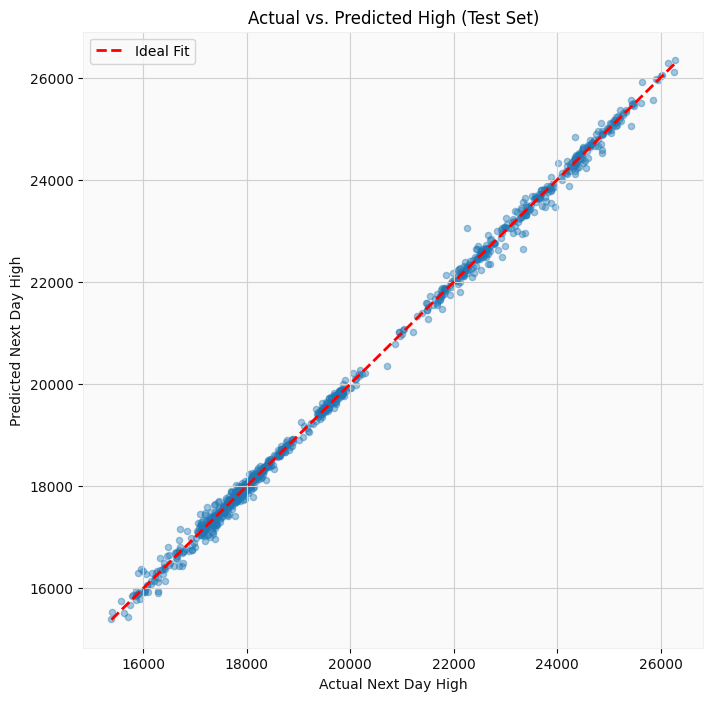

In [43]:
# Cell 18
print("\n--- Visualizing Actual vs. Predicted ---")
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.4, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Ideal Fit')
plt.xlabel("Actual Next Day High")
plt.ylabel("Predicted Next Day High")
plt.title("Actual vs. Predicted High (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

### 19. Model Evaluation: Plot Residuals

Plot the errors (residuals = actual - predicted) against the predicted values. For a good linear model, residuals should be randomly scattered around the horizontal zero line without any obvious patterns (like a curve or funnel shape).


--- Visualizing Residuals ---


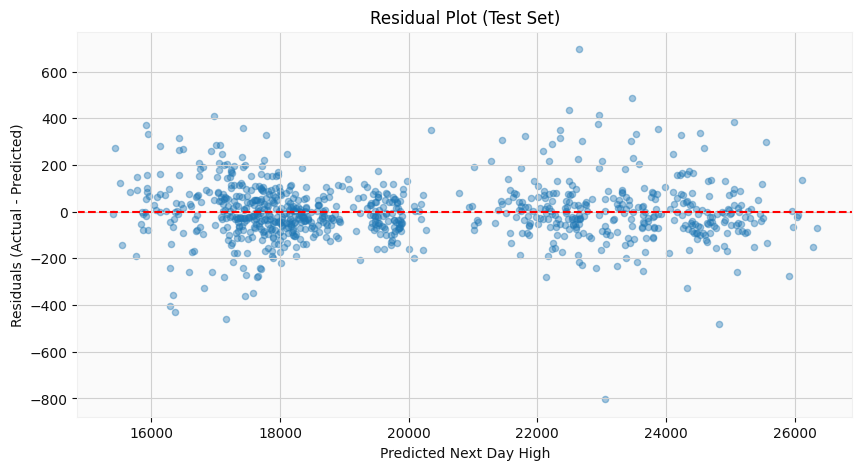

In [44]:
# Cell 19
print("\n--- Visualizing Residuals ---")
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.4, s=20)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Next Day High")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Test Set)")
plt.grid(True)
plt.show()

### 20. Model Evaluation: Plot Predictions Over Time (Visual Backtest)

Plot the actual high prices and the model's predicted high prices together over the time period of the test set. This gives a visual sense of how well the model tracks the actual price movements day-to-day.


--- Visualizing Predictions Over Time (Test Set) ---


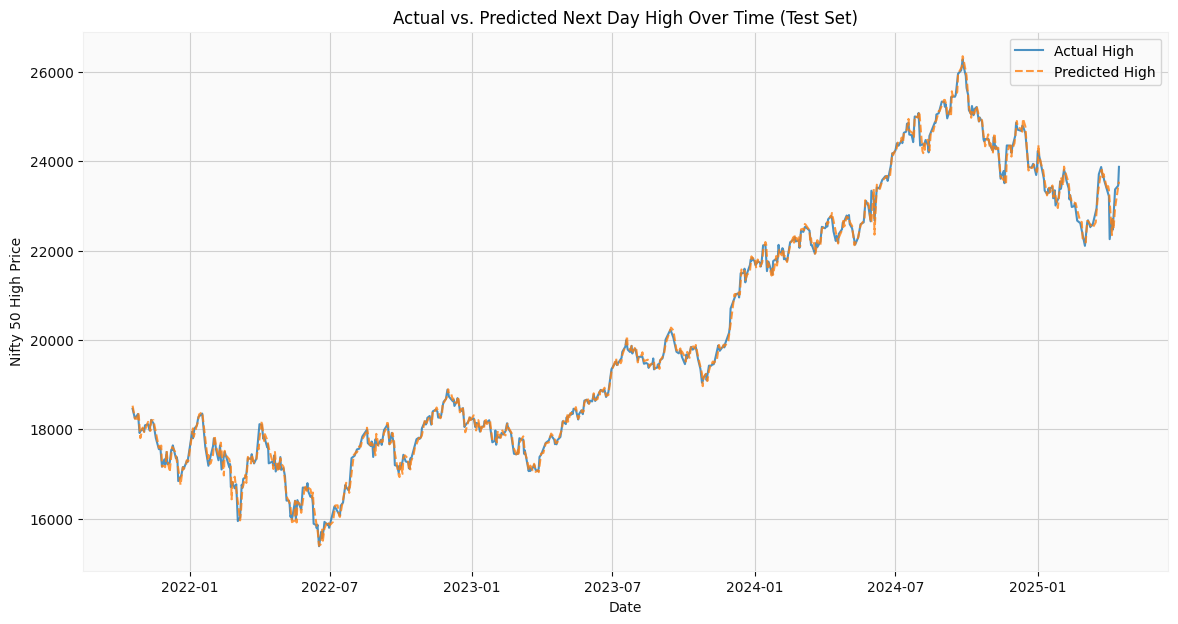

In [45]:
# Cell 20
print("\n--- Visualizing Predictions Over Time (Test Set) ---")
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual High', alpha=0.8)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted High', linestyle='--', alpha=0.8)
plt.title('Actual vs. Predicted Next Day High Over Time (Test Set)')
plt.xlabel('Date')
plt.ylabel('Nifty 50 High Price')
plt.legend()
plt.show()

### 21. Model Testing: Sample Predictions

Use the trained model and scaler to predict the high for the last 5 days in our test set and display the input features, actual high, and predicted high side-by-side.

In [46]:
# Cell 21
print("--- Testing Model on Last 5 Test Data Points ---")
X_test_last5 = X_test.tail(5)
X_test_scaled_last5 = X_test_scaled[-5:]
y_test_last5 = y_test.tail(5)
y_pred_last5 = lr_model.predict(X_test_scaled_last5)
comparison = pd.DataFrame({'Actual_High': y_test_last5, 'Predicted_High': y_pred_last5})
comparison = X_test_last5.join(comparison)
print(comparison)

--- Testing Model on Last 5 Test Data Points ---
                    open          high           low         close  \
Date                                                                 
2025-04-08  22446.750000  22697.199219  22270.849609  22535.849609   
2025-04-09  22460.300781  22468.699219  22353.250000  22399.150391   
2025-04-11  22695.400391  22923.900391  22695.400391  22828.550781   
2025-04-15  23368.349609  23368.349609  23207.000000  23328.550781   
2025-04-16  23344.099609  23452.199219  23273.050781  23437.199219   

             Actual_High  Predicted_High  
Date                                      
2025-04-08  22468.699219    22698.249401  
2025-04-09  22923.900391    22489.427898  
2025-04-11  23368.349609    22955.186611  
2025-04-15  23452.199219    23423.389814  
2025-04-16  23872.349609    23540.262360  


### 22. Save Artifacts

Save the trained Linear Regression model (`lr_model`) and the fitted scaler (`scaler`) object using `joblib`. These files are essential for deploying the model in the Streamlit web application.

In [47]:
# Cell 22
print("\n--- Saving Model and Scaler ---")
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)
model_path = os.path.join(models_dir, 'nifty_high_lr_model.joblib')
scaler_path = os.path.join(models_dir, 'ohlc_scaler.joblib')
joblib.dump(lr_model, model_path)
print(f"✅ Model saved to {model_path}")
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to {scaler_path}")


--- Saving Model and Scaler ---
✅ Model saved to models/nifty_high_lr_model.joblib
✅ Scaler saved to models/ohlc_scaler.joblib
